In [1]:
# Import the required packages
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import matplotlib.pyplot as plt


# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
data = load_files('C:\\Users\\Alpha\\Downloads\\dogImages\\dogImages\\train')

#x_train, y_train = load_dataset('C:\\Users\\Alpha\\Downloads\\dogImages\\dogImages\\train')
#x_valid, y_valid = load_dataset('C:\\Users\\Alpha\\Downloads\\dogImages\\dogImages\\valid')
#x_test , y_test  = load_dataset('C:\\Users\\Alpha\\Downloads\\dogImages\\dogImages\\test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("C:\\Users\\Alpha\\Downloads\\dogImages\\dogImages\\train\\*\\"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([x_train, x_valid, x_test])))
print('There are %d training dog images.' % len(x_train))
print('There are %d validation dog images.' % len(x_valid))
print('There are %d test dog images.'% len(x_test))


Using TensorFlow backend.


KeyboardInterrupt: 

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import pandas as pd
l = []
count = 0
for path in data['filenames']:
    img = load_img(path)
    try:
        l.append(img_to_array(img))
    except:
        print(img)
        print(count, "/", len(data['filenames']))
        exit(0)
        quit(0)
    count += 1
#arr = np.asarray(l)
#arr = np.asarray([img_to_array(load_img(path)) for path in data['filenames']])

In [ ]:
l = []

In [1]:
import tensorflow as tf
import keras 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
config = tf.config.experimental
gpu = tf.config.experimental.list_physical_devices('GPU')
for g in gpu : print(g,config.set_memory_growth(g, enable=True))

Using TensorFlow backend.


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') None


In [2]:
from keras import layers
from keras.models import Model
import keras.backend as K
from keras.utils import conv_utils

class OctConv2D(layers.Layer):
    def __init__(self, filters, alpha, beta, kernel_size=[3,3], strides=[1,1], 
                    padding="same", kernel_initializer='glorot_uniform',
                    kernel_regularizer=None, kernel_constraint=None,
                    **kwargs):
        """
        OctConv2D : Octave Convolution for image( rank 4 tensors)
        filters: # output channels for low + high
        alpha: Low channel ratio (alpha=0 -> High only, alpha=1 -> Low only)
        kernel_size : 3x3 by default, padding : same by default
        """
        #high    = 1 - alpha
        #medium  = beta
        #low     = alpha-beta
        assert alpha >= 0 and alpha <= 1
        assert beta >= 0  and beta <= 1
        assert filters > 0 and isinstance(filters, int)
        super().__init__(**kwargs)

        self.alpha  = alpha
        self.beta   = beta 
        self.filters = filters
        # optional values
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.kernel_initializer = kernel_initializer
        self.kernel_regularizer = kernel_regularizer
        self.kernel_constraint = kernel_constraint
        # -> Low Channels 
        self.low_channels   = int(self.filters * self.alpha)
        # -> Medium Channels
        self.medium_channels= int(self.filters * self.beta)
        # -> High Channles
        self.high_channels  = int(self.filters - self.medium_channels - self.low_channels )
        return
        
    def build(self, input_shape):
        assert len(input_shape) == 3
        assert len(input_shape[0]) == 4 and len(input_shape[1]) == 4 and len(input_shape[2]) == 4
        # Assertion for high inputs
        assert input_shape[0][1] // 2 >= self.kernel_size[0]
        assert input_shape[0][2] // 2 >= self.kernel_size[1]
        # Assertion for med inputs
        assert input_shape[0][1] // input_shape[1][1] == 2
        assert input_shape[0][2] // input_shape[1][2] == 2
        # Assertion for low inputs
        assert input_shape[1][1] // input_shape[2][1] == 2
        assert input_shape[1][2] // input_shape[2][2] == 2
        # channels last for TensorFlow
        assert K.image_data_format() == "channels_last"
        # input channels
        high_in     = int(input_shape[0][3])
        medium_in   = int(input_shape[1][3])
        low_in      = int(input_shape[2][3])

        """
        HIGH
        """
        # High -> High
        self.high_to_high_kernel = self.add_weight(name="high_to_high_kernel", 
                                    shape=(*self.kernel_size, high_in, self.high_channels),
                                    initializer=self.kernel_initializer,
                                    regularizer=self.kernel_regularizer,
                                    constraint=self.kernel_constraint)
        # High -> Medium
        self.high_to_medium_kernel = self.add_weight(name="high_to_medium_kernel", 
                                    shape=(*self.kernel_size, high_in, self.medium_channels),
                                    initializer=self.kernel_initializer,
                                    regularizer=self.kernel_regularizer,
                                    constraint=self.kernel_constraint)
        # High -> Low
        self.high_to_low_kernel  = self.add_weight(name="high_to_low_kernel", 
                                    shape=(*self.kernel_size, high_in, self.low_channels),
                                    initializer=self.kernel_initializer,
                                    regularizer=self.kernel_regularizer,
                                    constraint=self.kernel_constraint)
        """
        MEDIUM
        """
        # Medium-> High
        self.medium_to_high_kernel = self.add_weight(name="medium_to_high_kernel", 
                                    shape=(*self.kernel_size, medium_in, self.high_channels),
                                    initializer=self.kernel_initializer,
                                    regularizer=self.kernel_regularizer,
                                    constraint=self.kernel_constraint)
        
         # Medium-> Medium
        self.medium_to_medium_kernel = self.add_weight(name="medium_to_medium_kernel", 
                                    shape=(*self.kernel_size, medium_in, self.medium_channels),
                                    initializer=self.kernel_initializer,
                                    regularizer=self.kernel_regularizer,
                                    constraint=self.kernel_constraint)

         # Medium-> Low
        self.medium_to_low_kernel = self.add_weight(name="medium_to_low_kernel", 
                                    shape=(*self.kernel_size, medium_in, self.low_channels),
                                    initializer=self.kernel_initializer,
                                    regularizer=self.kernel_regularizer,
                                    constraint=self.kernel_constraint)
        
        """
        LOW
        """
        # Low -> High
        self.low_to_high_kernel  = self.add_weight(name="low_to_high_kernel", 
                                    shape=(*self.kernel_size, low_in, self.high_channels),
                                    initializer=self.kernel_initializer,
                                    regularizer=self.kernel_regularizer,
                                    constraint=self.kernel_constraint)
        # Low -> Medium
        self.low_to_medium_kernel  = self.add_weight(name="low_to_medium_kernel", 
                                    shape=(*self.kernel_size, low_in, self.medium_channels),
                                    initializer=self.kernel_initializer,
                                    regularizer=self.kernel_regularizer,
                                    constraint=self.kernel_constraint)
        # Low -> Low
        self.low_to_low_kernel   = self.add_weight(name="low_to_low_kernel", 
                                    shape=(*self.kernel_size, low_in, self.low_channels),
                                    initializer=self.kernel_initializer,
                                    regularizer=self.kernel_regularizer,
                                    constraint=self.kernel_constraint)
        super().build(input_shape)

        
            
            
    def call(self, inputs):
        # Input = [X^H, X^M, X^L]
        assert len(inputs) == 3
        high_input, medium_input, low_input = inputs
        """HIGH"""
        # High -> High conv
        high_to_high = K.conv2d(high_input, self.high_to_high_kernel,
                                strides=self.strides, padding=self.padding,
                                data_format="channels_last")
        # High -> Medium conv
        high_to_medium  = K.pool2d(high_input, (2,2), strides=(2,2), pool_mode="avg") #det ska va med just här                  >>
        high_to_medium  = K.conv2d(high_to_medium, self.high_to_medium_kernel,
                                strides=self.strides, padding=self.padding,
                                data_format="channels_last")
        # High -> Low conv
        high_to_low  = K.pool2d(high_input, (4,4), strides=(4,4), pool_mode="avg")  #Så att med variabeln går att använda här  <<
        high_to_low  = K.conv2d(high_to_low, self.high_to_low_kernel,
                                strides=self.strides, padding=self.padding,
                                data_format="channels_last")
        """MEDIUM"""
        # Medium -> High    conv
        medium_to_high  = K.conv2d(medium_input, self.medium_to_high_kernel,
                                strides=self.strides, padding=self.padding,
                                data_format="channels_last")
        medium_to_high = K.repeat_elements(medium_to_high, 2, axis=1) # Nearest Neighbor Upsampling
        medium_to_high = K.repeat_elements(medium_to_high, 2, axis=2)
      
        # Medium -> Medium  conv
        medium_to_medium  = K.conv2d(medium_input, self.medium_to_medium_kernel,
                                strides=self.strides, padding=self.padding,
                                data_format="channels_last")
        # Medium -> Low     conv
        medium_to_low  = K.pool2d(medium_input, (2,2), strides=(2,2), pool_mode="avg")
        medium_to_low  = K.conv2d(medium_to_low, self.medium_to_low_kernel,
                                strides=self.strides, padding=self.padding,
                                data_format="channels_last")
        """LOW"""
        # Low -> High conv
        low_to_high  = K.conv2d(low_input, self.low_to_high_kernel,
                                strides=self.strides, padding=self.padding,
                                data_format="channels_last")
        low_to_high = K.repeat_elements(low_to_high, 4, axis=1) # Nearest Neighbor Upsampling
        low_to_high = K.repeat_elements(low_to_high, 4, axis=2)

        # Low -> Medium conv
        low_to_medium = K.conv2d(low_input, self.low_to_medium_kernel,
                                strides=self.strides, padding=self.padding,
                                data_format="channels_last")
        low_to_medium = K.repeat_elements(low_to_medium, 2, axis=1) # Nearest Neighbor Upsampling
        low_to_medium = K.repeat_elements(low_to_medium, 2, axis=2)
        
        # Low -> Low conv
        low_to_low   = K.conv2d(low_input, self.low_to_low_kernel,
                                strides=self.strides, padding=self.padding,
                                data_format="channels_last")

        # Cross Add
        high_add = high_to_high + medium_to_high + low_to_high 
        medium_add = high_to_medium + medium_to_medium + low_to_medium
        low_add = high_to_low + medium_to_low + low_to_low 
        return [high_add, medium_add, low_add]

    def compute_output_shape(self, input_shapes):
        high_in_shape, medium_in_shape, low_in_shape = input_shapes
        high_out_shape = (*high_in_shape[:3], self.high_channels)
        medium_out_shape=(*medium_in_shape[:3],self.medium_channels)
        low_out_shape = (*low_in_shape[:3], self.low_channels)
        return [high_out_shape,medium_out_shape, low_out_shape]

    def get_config(self):
        base_config = super().get_config()
        out_config = {
            **base_config,
            "filters": self.filters,
            "alpha": self.alpha,
            "beta":self.beta,
            "filters": self.filters,
            "kernel_size": self.kernel_size,
            "strides": self.strides,
            "padding": self.padding,
            "kernel_initializer": self.kernel_initializer,
            "kernel_regularizer": self.kernel_regularizer,
            "kernel_constraint": self.kernel_constraint,            
        }
        return out_config
    def output_masks(a="g",b=""):
        return "troll troolll"
    

In [3]:
from keras.datasets import cifar10 as datasetrespo
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Concatenate
from keras.layers import Conv2D, MaxPooling2D, AvgPool2D, BatchNormalization, Add,add, Lambda,UpSampling2D,LeakyReLU
from keras.models import Model
import os
import keras.backend as K
from tensorflow.python import debug as tf_debug
from random import seed
from numpy.random import seed as numpy_seed

seed(1337)
numpy_seed(420)
tf.random.set_seed(80085)

should_train = True

# Define hyperparameters 
batch_size = 10
num_classes = 10
epochs = 20
num_predictions = 20


# Data splitting
(x_train, y_train), (x_test, y_test) = datasetrespo.load_data()

# One-hot encoding
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

# high, medium, low
inpt    = Input(x_train.shape[1:])
high    = inpt
medium  = AvgPool2D((2,2), padding='valid')(high)
low     = AvgPool2D((2,2), padding='valid')(medium)
testnet_layers = [high, medium, low]
conv_layers = []
num_layers = 9
filters = 32
alpha= [0.25 for i in range(num_layers)]
beta = [0.25  for i in range(num_layers)]

def contract_conv2(input_x, filters, alpha, beta):
    high, medium, low = input_x
    high, medium, low = OctConv2D(filters, alpha, beta)([high, medium, low])
    high   = Dropout(0.1)(BatchNormalization()(LeakyReLU(alpha=0.1)(high)))
    medium = BatchNormalization()(LeakyReLU(alpha=0.1)(medium))
    low    = BatchNormalization()(LeakyReLU(alpha=0.1)(low))
    return [high,medium, low]

def contract_conv(input_x, filters, alpha, beta):
    output_x = contract_conv2(input_x, filters, alpha, beta)
    output_x = contract_conv2(input_x, filters, alpha, beta)
    return [Add()([input_x[i], output_x[i]])for i in range(3)]

count = 0
for i in range(num_layers):
    if count %4 == 0:
        filters *= 2
        testnet_layers = contract_conv2(testnet_layers, filters, alpha[i], beta[i])
    count += 1
    testnet_layers = contract_conv(testnet_layers, filters, alpha[i], beta[i])
    

#testnet_layers = OctConv2D(10,alpha=0.2,beta=0.1)(testnet_layers)
aa = testnet_layers[0]
bb = UpSampling2D(size=(2,2),interpolation='nearest')(testnet_layers[1])
cc = UpSampling2D(size=(4,4),interpolation='nearest')(testnet_layers[2])

print(aa.shape, bb.shape, cc.shape)
a = Concatenate(axis=-1)([aa,bb,cc])
print(a.shape)
x = Flatten()(a)
x = Dense(100)(x)
x = Dropout(0.1)(x)
x = Dense(num_classes)(x)
output_layer = Activation('softmax')(x)
model = Model(inputs=inpt,outputs=output_layer)
#model.summary()


# Training
model.compile(loss='sparse_categorical_crossentropy',
optimizer='Adam',
metrics=['sparse_categorical_accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
model.summary()

print("FITTTTING")

(None, 32, 32, 128) (None, 32, 32, 64) (None, 32, 32, 64)
(None, 32, 32, 256)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
average_pooling2d_1 (AveragePoo (None, 16, 16, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
average_pooling2d_2 (AveragePoo (None, 8, 8, 3)      0           average_pooling2d_1[0][0]        
__________________________________________________________________________________________________
oct_conv2d_1 (OctConv2D)        [(None, 32, 32, 32), 5184        input_1[0][0]                    
              

In [1]:
from keras.utils.vis_utils import plot_model
plot_model(model)

Using TensorFlow backend.


NameError: name 'model' is not defined

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [5]:
print(tf.__version__)

2.1.0


In [6]:
seed(1337)
numpy_seed(420)
tf.random.set_seed(80085)
print("FITTTTING")
if should_train:
    history = model.fit(x_train,y_train, batch_size=batch_size,epochs=epochs,validation_data=(x_test, y_test), shuffle=True)

    # Save model and weights
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    # Model save
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    model_name = 'epochs10_9_layers-20-epochs-alpha0.05-beta0.1.h5'
    model_path = os.path.join(save_dir, model_name)
    model.save(model_path)
    print('Saved trained model at %s ' % model_path)

    # Score trained model.
    scores = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])


FITTTTING
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 576s 12ms/step - loss: 13.9647 - sparse_categorical_accuracy: 0.3623 - val_loss: 1.8411 - val_sparse_categorical_accuracy: 0.4155
Epoch 2/20
50000/50000 [==============================] - 558s 11ms/step - loss: 1.9310 - sparse_categorical_accuracy: 0.4027 - val_loss: 2.4807 - val_sparse_categorical_accuracy: 0.2908
Epoch 3/20
50000/50000 [==============================] - 553s 11ms/step - loss: 1.9169 - sparse_categorical_accuracy: 0.4692 - val_loss: 1.9600 - val_sparse_categorical_accuracy: 0.5483
Epoch 4/20
50000/50000 [==============================] - 555s 11ms/step - loss: 1.7975 - sparse_categorical_accuracy: 0.5422 - val_loss: 3.2799 - val_sparse_categorical_accuracy: 0.5440
Epoch 5/20
50000/50000 [==============================] - 565s 11ms/step - loss: 1.7178 - sparse_categorical_accuracy: 0.5867 - val_loss: 2.0627 - val_sparse_categorical_accuracy: 0.6122
Epoc

NameError: name 'save_dir' is not defined

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


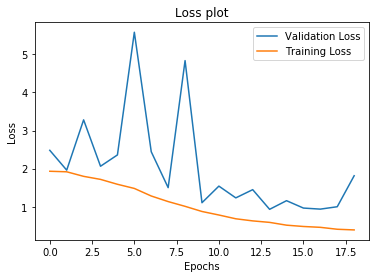

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


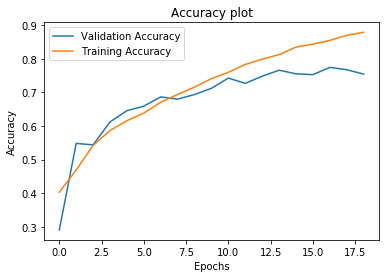

In [9]:
his = history.history
loss = ['val_loss', 'loss']
names_loss = ['Validation Loss', 'Training Loss']
acc  = ['val_sparse_categorical_accuracy','sparse_categorical_accuracy']
names_acc = ['Validation Accuracy', 'Training Accuracy']
for k, k2 in zip(loss,names_loss):
    plt.plot(his[k][1:], label=k2)
    plt.legend()
plt.title("Loss plot")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig('saved_models\octCovLossHML2.eps', format='eps')
plt.show()
for k, k2 in zip(acc,names_acc):
    plt.plot(his[k][1:], label=k2)
    plt.legend()
plt.title("Accuracy plot")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig('saved_models\octCovAccHML2.eps', format='eps')
plt.show()

In [17]:
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    model_name = 'epochs10_9_layers-20-epochs-alpha0.05-beta0.1__v2.22.h5'
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    # Model save
    model_path = os.path.join(save_dir, model_name)
    tf.compat.v1.export_saved_model(model,model_path)
    print('Saved trained model at %s ' % model_path)

AttributeError: module 'tensorflow_core.compat.v1' has no attribute 'export_saved_model'

In [10]:
import pandas as pd
df = pd.DataFrame.from_dict(his)
df.to_csv("saved_models\histOctConvHML2")

In [ ]:
224s   175s 155s 